# 1. Build your own neural network with 3 hidden layers using pytorch (60 points)

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image
import pandas as pd
import os
import cv2

import warnings
warnings.filterwarnings("ignore")

import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms

In [94]:
class CustomNN(nn.Module):
    def __init__(self, feature_size, hidden_size1, hidden_size2, hidden_size3, num_outputs):
        super(CustomNN, self).__init__()
        self.fc1 = nn.Linear(feature_size, hidden_size1)
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity="relu")
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity="relu")
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity="relu")
        self.fc_output = nn.Linear(hidden_size3, num_outputs)
       
    def forward(self, input_data):
        input_data = input_data.view(input_data.size(0), -1)  # Flatten the input tensor
        output = torch.nn.functional.relu(self.fc1(input_data))
        output = torch.nn.functional.relu(self.fc2(output))
        output = torch.nn.functional.relu(self.fc3(output))
        output = self.fc_output(output)
        return output


# 2. Train your model using cow teat datasets (30 points)

## You can resize the image to 75 * 75 *3

In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset

# Define transformations for the training and validation sets
data_transforms = transforms.Compose([
    transforms.Resize((75, 75)),   # Resize images to 75x75
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Load training datasets from two folders
train_data1 = datasets.ImageFolder(root='C:/Users/acer/Downloads/Train_1', 
                                     transform=data_transforms)
train_data2 = datasets.ImageFolder(root='C:/Users/acer/Downloads/Train_2', 
                                     transform=data_transforms)

# Concatenate the training datasets
train_dataset = ConcatDataset([train_data1, train_data2])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load validation dataset
val_dataset = datasets.ImageFolder(root='C:/Users/acer/Downloads/Test', 
                                     transform=data_transforms)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define hyperparameter grid
learning_rates = [0.001, 0.0001]
num_epochs_list = [3, 5]

# Define input, hidden, and output dimensions
input_dim = 75 * 75 * 3
hidden_dim1 = 512
hidden_dim2 = 256
hidden_dim3 = 128
output_dim = 3

# Define your model (assuming the NeuralNetwork class is defined elsewhere)
model = NeuralNetwork(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

# Function to train and evaluate the model
def train_and_evaluate(learning_rate, num_epochs):    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader.dataset)
        accuracy = correct / total

        # Update best model state if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
    
    return best_val_loss, best_model_state, accuracy

# Perform grid search
best_hyperparams = None
best_val_loss = float('inf')
best_accuracy = 0

for lr in learning_rates:
    for epochs in num_epochs_list:
        print(f"Training with learning rate {lr} and {epochs} epochs")
        val_loss, model_state, accuracy = train_and_evaluate(lr, epochs)
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")
        
        # Update best hyperparameters if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_hyperparams = (lr, epochs)
            best_accuracy = accuracy
            best_model_state = model_state

print(f"Best Hyperparameters: Learning Rate = {best_hyperparams[0]}, Epochs = {best_hyperparams[1]}")
print(f"Best Validation Loss: {best_val_loss:.4f}, Best Accuracy: {best_accuracy:.4f}")

# Load best model state
model.load_state_dict(best_model_state)


Training with learning rate 0.001 and 3 epochs
Validation Loss: 0.4663, Accuracy: 0.9947
Training with learning rate 0.001 and 5 epochs
Validation Loss: 0.4474, Accuracy: 0.1395
Training with learning rate 0.0001 and 3 epochs
Validation Loss: 0.5487, Accuracy: 0.6026
Training with learning rate 0.0001 and 5 epochs
Validation Loss: 0.5247, Accuracy: 0.6211
Best Hyperparameters: Learning Rate = 0.001, Epochs = 5
Best Validation Loss: 0.4474, Best Accuracy: 0.1395


<All keys matched successfully>

In [91]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Create a custom dataset class that includes file names
class CustomImageDataset(Dataset):
    def __init__(self, root_directory, transform=None):
        self.root_directory = root_directory
        self.transform = transform
        self.image_file_paths = []
        self.image_file_names = []
        
        # Iterate through all directories (labels) in the root directory
        for label in os.listdir(root_directory):
            label_directory = os.path.join(root_directory, label)
            if os.path.isdir(label_directory):  # Check if it is a directory
                for file_name in os.listdir(label_directory):
                    if file_name.endswith(('.png', '.jpg', '.jpeg')):  # Check for image file types
                        self.image_file_paths.append(os.path.join(label_directory, file_name))
                        self.image_file_names.append(file_name)

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, index):
        img_path = self.image_file_paths[index]
        img_name = self.image_file_names[index]
        image = Image.open(img_path).convert("RGB")        
        if self.transform:
            image = self.transform(image)
        return image, img_path, img_name

# Create a test data loader
test_batch_size = 8
test_dataset = CustomImageDataset(root_directory='C:/Users/acer/Downloads/Test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

# Predict on the test data loader and save file names with predictions
all_predictions = []
all_file_names = []
all_file_paths = []

with torch.no_grad():  # Disable gradient calculations for inference
    for inputs, file_paths, file_names in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_file_names.extend(file_names)
        all_file_paths.extend(file_paths)

# Create a dictionary with file names and predictions
prediction_data = {'File Name': all_file_names, 'Predicted Label': all_predictions}

# Convert the dictionary to a pandas DataFrame
prediction_df = pd.DataFrame(prediction_data)

# Save the DataFrame to a CSV file
output_csv_path = 'C:/Users/acer/Downloads/neuralnetworkpred.csv'
prediction_df.to_csv(output_csv_path, index=False, header=False)


# 3. Evaluate your model using the developed software (10 points)
## Grading Rubric:
## (1). > = 50% -->10 points
## (2). < 30 % -->0 points
## (2). >= 30 % & < 50% -->0.5 point/percent

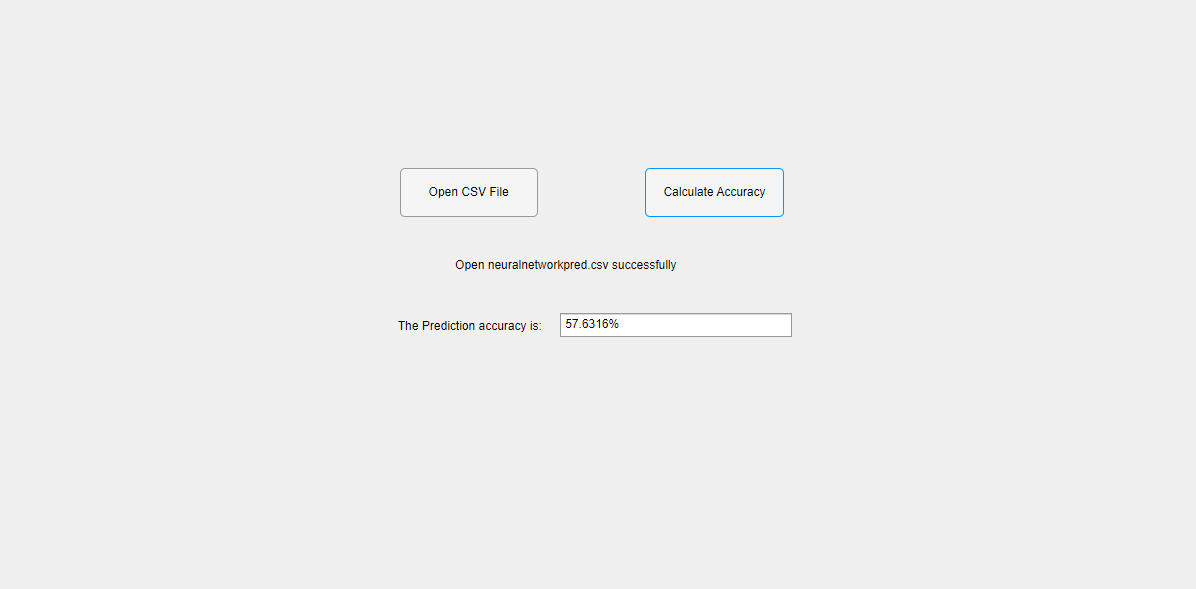